# Function

In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(scater)
})

readCellphoneDB <- function(sample, corrected_p = TRUE) {
  deconfile = "deconvoluted.txt"
  meanfile = "means.txt"
  pvaluefile = "pvalues.txt"
  significantfile = "significant_means.txt"
  #sample = "./data/pipeline_output/cellphonedb/SS2-D20171109"
  decon <- as.data.frame(readr::read_tsv(file.path(sample, deconfile), guess_max = 10000))
  means <- as.data.frame(readr::read_tsv(file.path(sample, meanfile), guess_max = 10000))
  sig <- as.data.frame(readr::read_tsv(file.path(sample, significantfile),guess_max = 10000))
  pvalues <- as.data.frame(readr::read_tsv(file.path(sample, pvaluefile), guess_max = 10000)  )
  
  
  
  interact_meta <- means[,1:11]
  means <- as.matrix(means[, 12:ncol(means)])

  pvalue_meta <- pvalues[, 1:11]
  pvalues <- as.matrix(pvalues[, 12:ncol(pvalues)])
  
  sig_ranks <- sig[, 1:12]
  sig <- as.matrix(sig[, 13:ncol(sig)])
  
  


    
  # Assign rownames
  rownames(sig_ranks) <- sig_ranks$id_cp_interaction
  rownames(sig) <- sig_ranks$id_cp_interaction  
 rownames(pvalues) <- pvalue_meta$id_cp_interaction
  rownames(means) <- interact_meta$id_cp_interaction
  rownames(interact_meta) <- interact_meta$id_cp_interaction

    
  if(corrected_p) {
      pvalues <- t(apply(pvalues, 1, p.adjust, method = 'fdr'))
  }

  #--- Filter rank
  keep <- rownames(sig_ranks)[which(sig_ranks$rank < 1)]
  
  means <- means[keep, ]    
  sig <- sig[keep, ]
  pvalues <- pvalues[keep,]
  interact_meta <- interact_meta[keep,]
  sig_ranks <- sig_ranks[keep, ]
        
  
  # filter complex pair
    
  keep <- rownames(sig_ranks)[which(!grepl("complex", sig_ranks$interacting_pair))]
  means <- means[keep, ]    
  sig <- sig[keep, ]
  pvalues <- pvalues[keep,]
  interact_meta <- interact_meta[keep,]
  sig_ranks <- sig_ranks[keep, ]


  
 
    
  return(list(mean = means, pvalue = pvalues, significant = sig, significant_rank = sig_ranks, meta = interact_meta))
}




getSignificantPairs <- function(cpdb.list, pvalue.cutoff = 0.01) {
  sig <- cpdb.list$significant
  means <- cpdb.list$mean
  pvalues <- cpdb.list$pvalue
  meta <- cpdb.list$meta
  
  
  plotdata <- setNames(reshape2::melt(pvalues), c("id_cp_interaction", "cluster_pair", "pvalue")) 
  plotdata <- left_join(plotdata, setNames(reshape2::melt(means), c("id_cp_interaction", "cluster_pair", "mean")) ) 
  plotdata <- left_join(plotdata, meta)
  plotdata <- plotdata %>% 
   filter(pvalue < pvalue.cutoff) %>% 
   #arrange(desc(rank)) %>% 
   
   #dplyr::mutate(pvalue_plot = ifelse(pvalue == 0, 0.0009, pvalue)) %>% 
   dplyr::mutate(cluster_a = sapply(strsplit(as.character(cluster_pair), "\\|"), `[[`, 1),
           cluster_b = sapply(strsplit(as.character(cluster_pair), "\\|"), `[[`, 2))
   #filter(cluster_a != cluster_b) 
  return(plotdata)
}


# Read CellphoneDB interaction Result

In [2]:
cpdb_res <- readCellphoneDB(file.path("./out/AlltoAll_Avg1_simplified_celltype/"))


Rows: 1871 Columns: 52

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): gene_name, uniprot, protein_name, complex_name, id_cp_interaction
dbl (46): B_C01.MS4A1, B_C02.CD79A, CAF_C01.FAP, CAF_C02.CD36, CD4.CD8_C01.L...
lgl  (1): is_complex


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 792 Columns: 2127

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr    (7): id_cp_interaction, interacting_pair, partner_a, partner_b, gene_...
dbl (2116): B_C01.MS4A1|B_C01.MS4A1, B_C01.MS4A1|B_C02.CD79A, B_C01.MS4A1|CA...
lgl    (4): secreted, receptor_a, receptor_b, is_integrin


ℹ Use `spec()` to retrieve the full column specif

In [3]:
topInteract <- getSignificantPairs(cpdb_res, pvalue.cutoff = 0.01)

Joining, by = c("id_cp_interaction", "cluster_pair")

Joining, by = "id_cp_interaction"



In [4]:
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")

## TPM 

In [5]:
assay(sce, "logtpm") <- log2(scater::calculateTPM(sce, rowData(sce)$Length) + 1)


# Retain only ligand-receptor interactions

In [6]:
topInteract_clean <- topInteract %>% 
    filter( !(receptor_a & receptor_b)) %>% 
    filter( !(!receptor_a  & !receptor_b)) %>% 
    filter(!grepl("complex", partner_b)) %>% 
    filter(!grepl("complex", partner_a)) %>% 
 mutate(sending = case_when(
        receptor_a & !receptor_b ~ cluster_b, 
        !receptor_a & receptor_b ~ cluster_a
    ),
    ligand = case_when(
        receptor_a & !receptor_b ~ gene_b, 
        !receptor_a & receptor_b ~ gene_a
    )) %>% 
mutate(receiver = case_when(
        receptor_a & !receptor_b ~ cluster_a, 
        !receptor_a & receptor_b ~ cluster_b
        ),
    receptor = case_when(
        receptor_a & !receptor_b ~ gene_a, 
        !receptor_a & receptor_b ~ gene_b
    )) %>%
mutate(sending = gsub("\\.", "-", sending)) %>% 
mutate(receiver = gsub("\\.", "-", receiver)) 

# Gather expression information

In [8]:
lr_genes <- unique(c(topInteract_clean$ligand , topInteract_clean$receptor))
exprDF <- makePerCellDF(sce, features = lr_genes, assay.type = "logtpm")


In [9]:
exprDF <- exprDF %>% 
    select(celltype, lr_genes) %>% 
    pivot_longer(cols = lr_genes , names_to = "gene",  values_to = "logtpm") %>%
    group_by(celltype, gene) %>%
    summarise( fractionExpr = sum(logtpm > 0)/n(), meanExpr = mean(logtpm) )

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(lr_genes)` instead of `lr_genes` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

`summarise()` has grouped output by 'celltype'. You can override using the `.groups` argument.



In [10]:
topInteract_clean <- topInteract_clean %>% 
    left_join(exprDF,  by = c("sending" = "celltype", "ligand" = "gene") ) %>%
    dplyr::rename(fractionExprLigand = fractionExpr, meanExprLigand = meanExpr) %>%
    left_join(exprDF,  by = c("receiver" = "celltype", "receptor" = "gene") ) %>%
    dplyr::rename(fractionExprReceptor = fractionExpr, meanExprReceptor = meanExpr)

# Write out clean result

In [10]:
readr::write_tsv(topInteract_clean, file = "./out/topInteraction_cellphonedb_clean.tsv" )

In [11]:
topInteract_clean <- readr::read_tsv("./out/topInteraction_cellphonedb_clean.tsv" )

Rows: 43766 Columns: 24

── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (14): id_cp_interaction, cluster_pair, interacting_pair, partner_a, part...
dbl  (6): pvalue, mean, fractionExprLigand, meanExprLigand, fractionExprRece...
lgl  (4): secreted, receptor_a, receptor_b, is_integrin


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



# Interaction count

In [12]:
ir_count_ht <- topInteract_clean %>% 
   mutate(LR = paste0(ligand, "-", receptor)) %>%
   filter(grepl("CAF|^HCC|^Mac|^NK|^VSMC", sending )) %>%  
   filter(grepl("CAF|^HCC|^Mac|^NK|^VSMC", receiver)) %>% 
  group_by(sending, receiver) %>% 
    summarise(count = n()) %>% 
    pivot_wider(names_from = receiver, values_from = count)

`summarise()` has grouped output by 'sending'. You can override using the `.groups` argument.



In [13]:
sending_pops <- ir_count_ht[[1]]
ir_count_ht <- as.matrix(ir_count_ht[, 2:ncol(ir_count_ht)])
rownames(ir_count_ht) <- sending_pops

In [14]:
rownames(ir_count_ht) 

[1] "CAF_C01-FAP"    "CAF_C02-CD36"   "HCC_D20170322"  "HCC_D20170327" 
 [5] "HCC_D20170412"  "HCC_D20171109"  "HCC_D20171220"  "HCC_D20180108" 
 [9] "HCC_D20180110"  "Mac_C01-THBS1"  "Mac_C02-C1QA"   "NK_C01-FCGR3A" 
[13] "NK_C02-CD160"   "NK_C03-IFNG"    "NK_C04-SELL"    "NK_C05-MKI67"  
[17] "VSMC_C03-MYH11"

In [15]:
split_fac <- c("Mes", 'Mes', "HCC", "HCC", "HCC", "HCC", "HCC", "HCC", "HCC", "Mac", "Mac", "NK", "NK", "NK", "NK", "NK", "Mes")

In [16]:
col1 = "dodgerblue4"
col2 = 'peachpuff'
col3 = 'deeppink4'

In [67]:
library(ComplexHeatmap)
col.heatmap <- colorRampPalette(c(col1,col2,col3 ))( 1000 )
pdf("./Heatmap_interaction_counts.pdf", height = 5, width = 6)
Heatmap(ir_count_ht, col = col.heatmap,border = T, name = 'Interactions (n)', clustering_method_columns = "ward.D2", clustering_method_rows = "ward.D2", column_split = split_fac,
        row_split = split_fac,
        row_names_side = 'left', show_column_dend = F, show_row_dend = F)
dev.off()

png 
  2

# Interaction ligand-receptor pairs

In [17]:
topInteract_CAF2tumor <- topInteract_clean %>% 
   mutate(LR = paste0(ligand, "-", receptor)) %>%
   filter(grepl("CAF", sending )) %>%  
   filter(grepl("^HCC|^Hepa", receiver)) %>% 
   mutate(group = "Tumor")

In [19]:
topInteract_CAF2NK <- topInteract_clean %>% 
   mutate(LR = paste0(ligand, "-", receptor)) %>%
   filter(grepl("CAF", sending )) %>%  
   filter(grepl("^NK", receiver)) %>% 
   mutate(group = "NK")

In [20]:
topInteract_CAF2Mac <- topInteract_clean %>% 
   mutate(LR = paste0(ligand, "-", receptor)) %>%
   filter(grepl("CAF", sending )) %>%  
   filter(grepl("^Mac", receiver)) %>% 
   mutate(group = "Mac")

# CAF to Tumor

In [21]:
plotInteractDF <- rbind(topInteract_CAF2tumor, topInteract_CAF2Mac, topInteract_CAF2NK) 

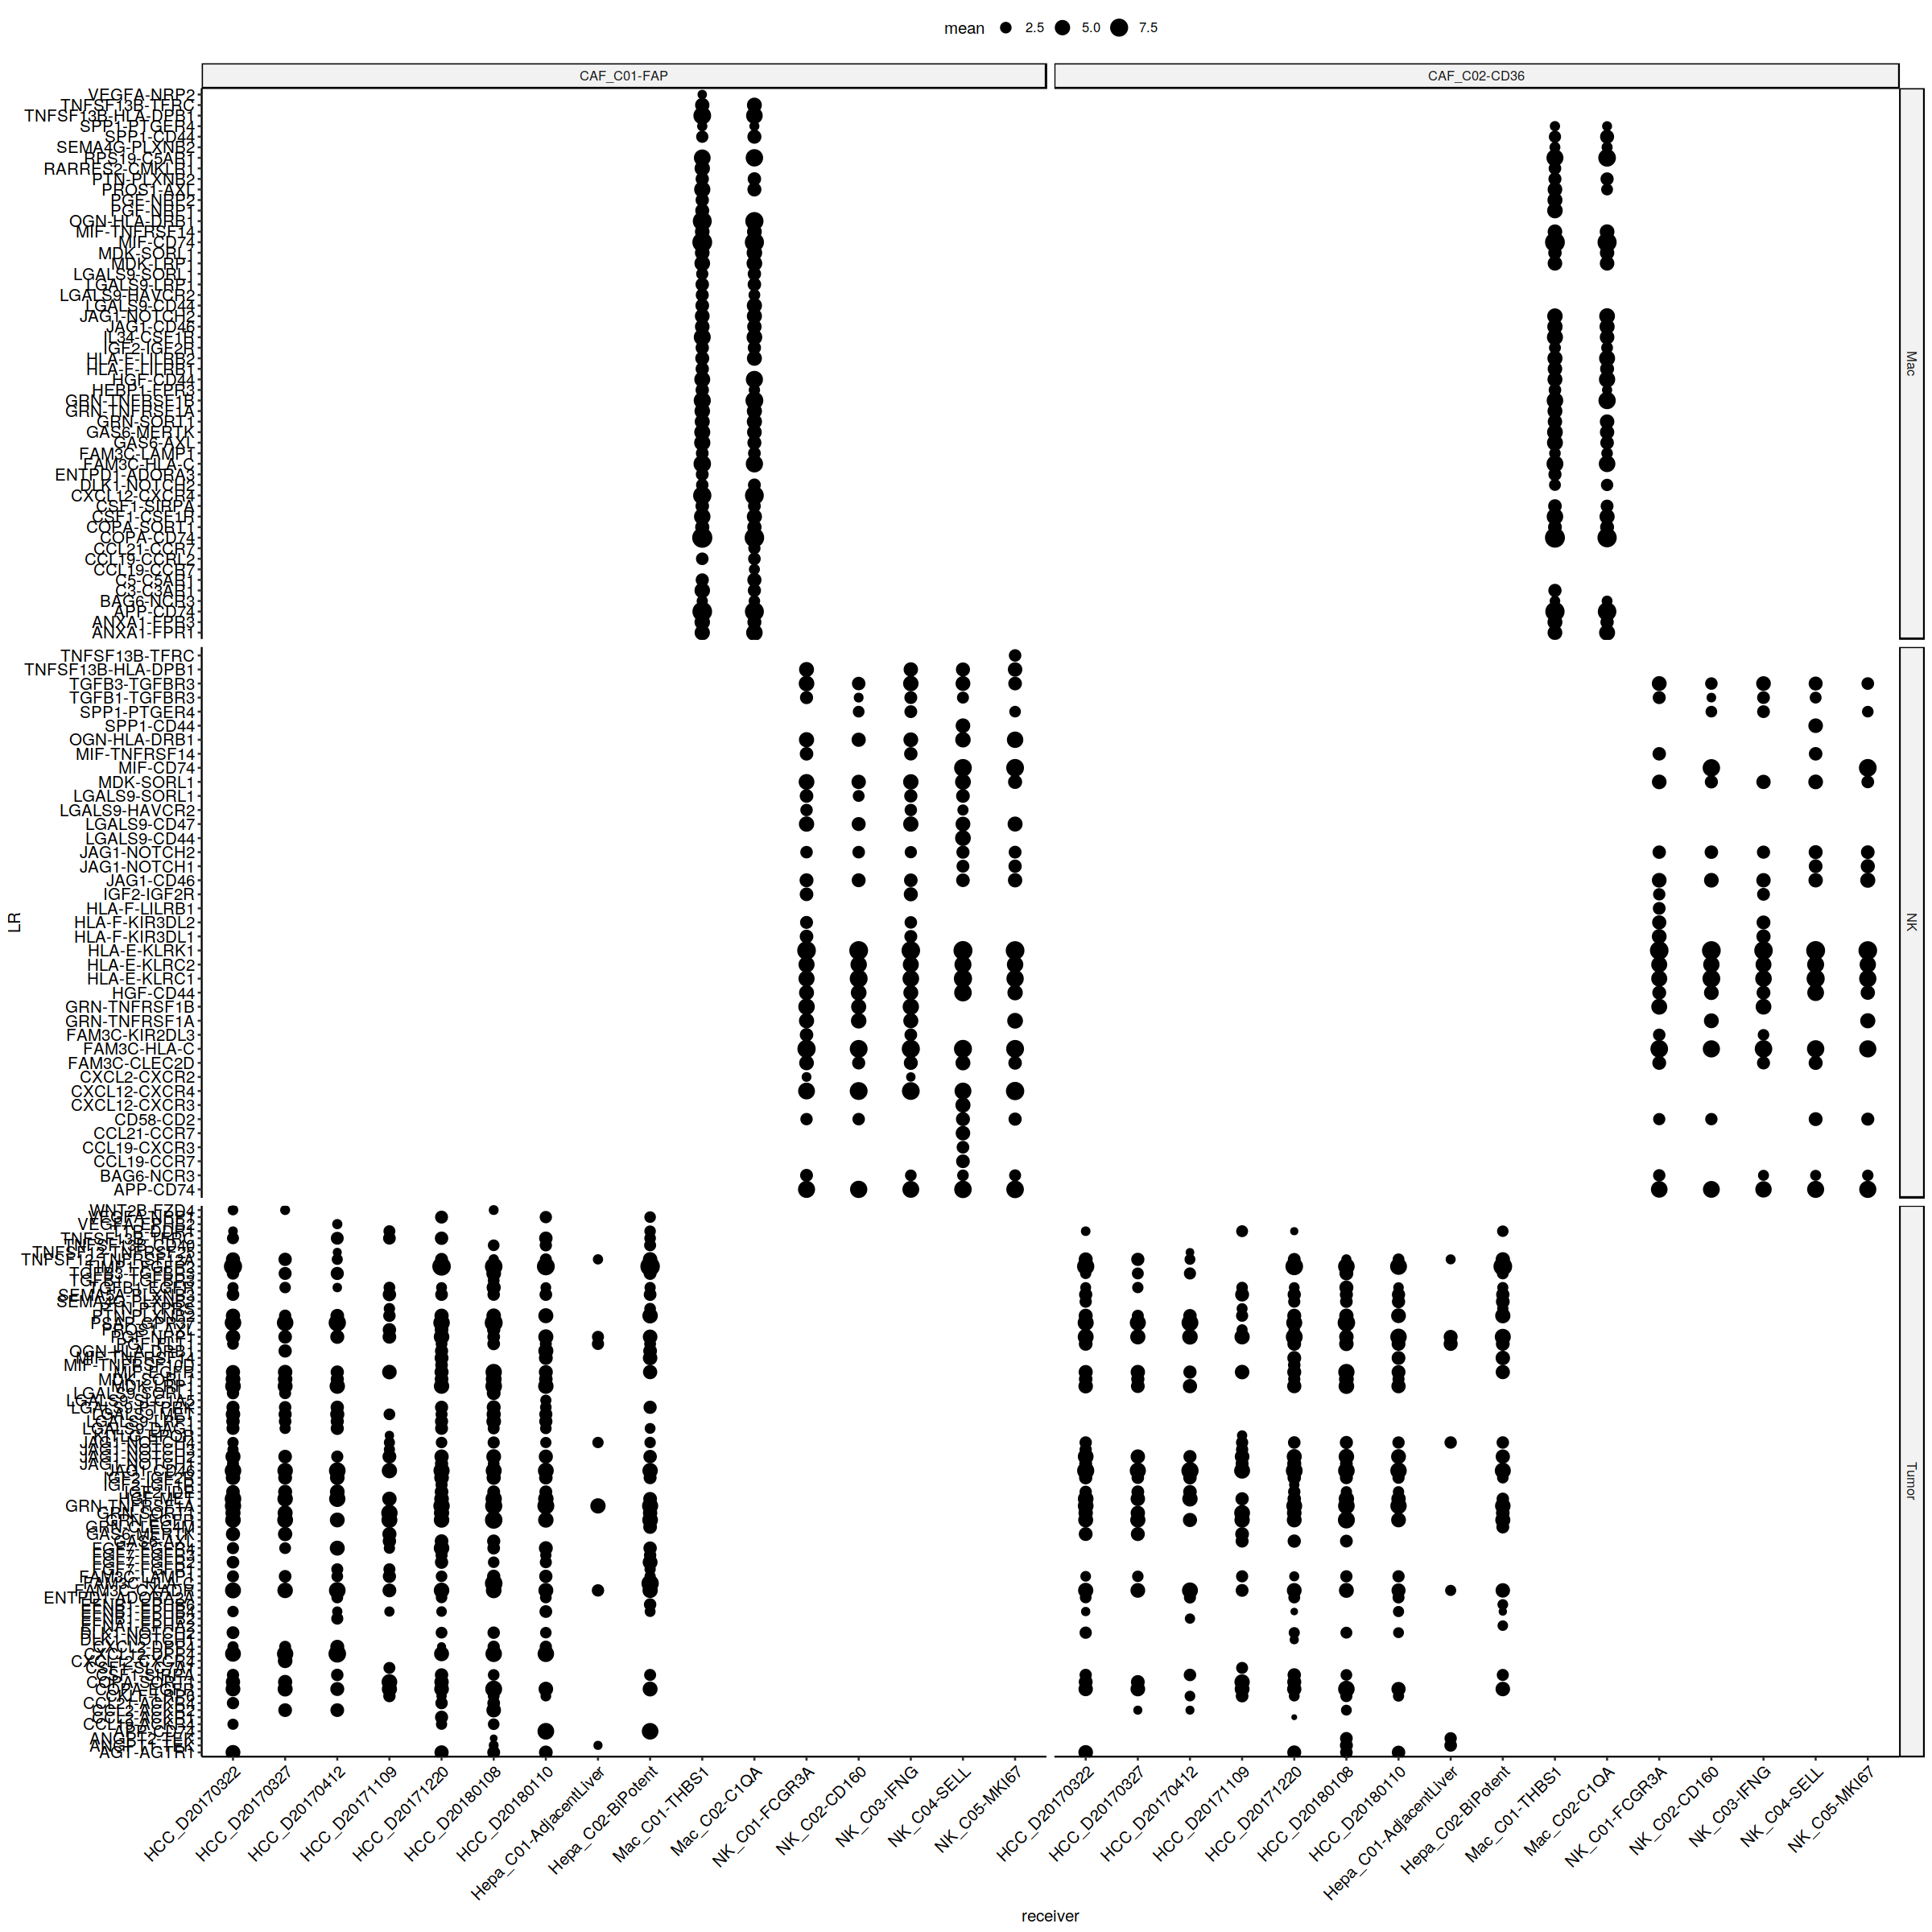

In [22]:
options(repr.plot.width = 20, repr.plot.height = 20)

ggplot(plotInteractDF, aes(x = receiver, y = LR)) +
    geom_point(aes(size = mean)) +
    facet_grid(group ~ sending, scales = "free") + 
    ggpubr::theme_pubr() + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

In [23]:
topInteract_CAF2tumor <- topInteract_CAF2tumor %>% filter(annotation_strategy != 'I2D')

In [24]:
LR_tumor_single <- topInteract_CAF2tumor %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 1)

LR_tumor_multiple <- topInteract_CAF2tumor %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 2)

In [25]:
LR_NK_single <- topInteract_CAF2NK %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 1)

LR_NK_multiple <- topInteract_CAF2NK %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 2)

In [26]:
LR_Mac_single <- topInteract_CAF2Mac %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 1)

LR_Mac_multiple <- topInteract_CAF2Mac %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 2)

In [27]:
LRpairs <- bind_rows(LR_Mac_multiple, LR_Mac_single, LR_NK_multiple, LR_NK_single, LR_tumor_multiple, LR_tumor_single) %>% 
    group_by(LR) %>% summarise(count = n()) %>% filter(count <= 2)

In [28]:
plotInteractDF <- rbind(topInteract_CAF2tumor, topInteract_CAF2Mac, topInteract_CAF2NK) %>%
    filter(LR %in% LRpairs$LR)

In [29]:
LRorder <- plotInteractDF %>% 
    filter(grepl("^Mac", receiver)) %>%
    group_by(LR) %>% summarise(count = n()) %>% arrange(desc(count)) %>% distinct(LR) 

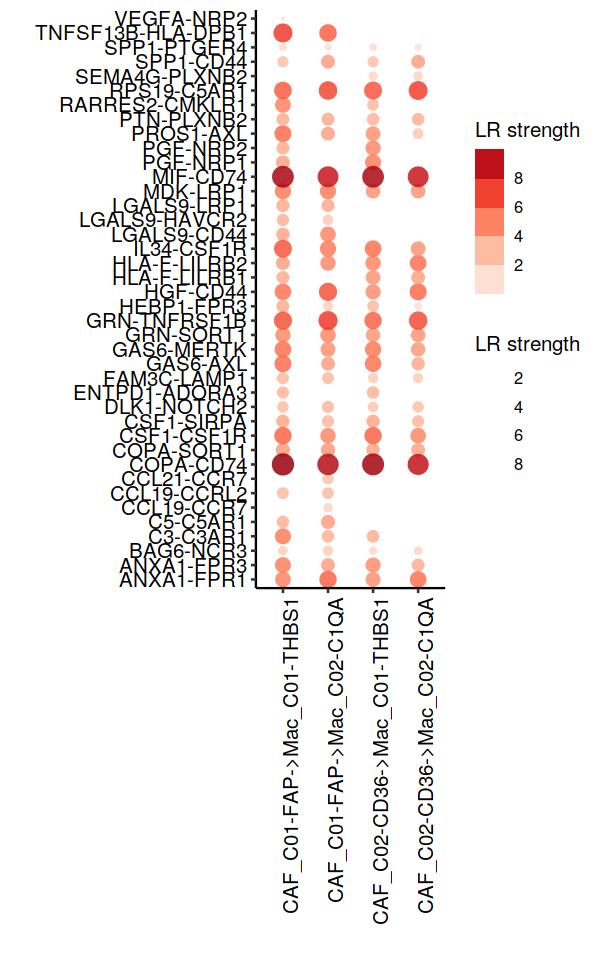

In [186]:
options(repr.plot.height = 8, repr.plot.width = 5)
p1 <- plotInteractDF %>% 
    filter(grepl("^Mac", receiver)) %>%
 mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    ggplot( aes(x = paste0(sending, "->", receiver), y = LR)) +
    geom_point(aes(size = mean,  fill = mean, color = mean), shape = 21, alpha = .85,  stroke = .001 ) +
    scale_fill_distiller(palette = "Reds", direction = 1) + 
    scale_color_distiller(palette = "Reds", direction = 1) + 

    #scale_size(range = c(0, 10)) + 
    guides(fill = guide_colorsteps(title = 'LR strength'),color = guide_colorsteps(title = 'LR strength'), size = guide_legend(title = 'LR strength')) +
    ylab("") + xlab("") +
    ggpubr::theme_pubr() + theme(legend.position = 'right', axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) 
p1

ggsave(p1, filename = "../figures/Figure2/2D_Dotplot_LR_CAF2Mac.pdf", width = 5, height = 9)

In [30]:
LRorder <- plotInteractDF %>% 
    filter(grepl("^HCC", receiver)) %>%
    group_by(LR) %>% summarise(count = n()) %>% arrange(desc(count)) %>% distinct(LR) 

In [32]:
plotInteractDF %>% 
    filter(grepl("^HCC", receiver)) %>%
    mutate(LR = factor(LR, levels = rev(LRorder[[1]]))) %>% 
 mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) 

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR,group
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
CPI-SS0E928B8C8,CAF_C01.FAP|HCC_D20170322,0.009,3.073,FGF7_FGFR2,simple:P21781,simple:P21802,FGF7,FGFR2,TRUE,⋯,CAF_C01-FAP,FGF7,HCC_D20170322,FGFR2,0.4310345,2.6560221,0.5384615,2.5466941,FGF7-FGFR2,Tumor
CPI-SS01469637C,CAF_C01.FAP|HCC_D20170322,0.009,2.062,WNT2B_FZD4,simple:Q93097,simple:Q9ULV1,WNT2B,FZD4,TRUE,⋯,CAF_C01-FAP,WNT2B,HCC_D20170322,FZD4,0.3620690,1.1574222,0.5000000,1.9623595,WNT2B-FZD4,Tumor
CPI-SS00AEC3818,CAF_C01.FAP|HCC_D20170322,0.009,2.296,CCL19_ACKR4,simple:Q99731,simple:Q9NPB9,CCL19,ACKR4,TRUE,⋯,CAF_C01-FAP,CCL19,HCC_D20170322,ACKR4,0.4310345,4.6659913,0.3461538,0.9695084,CCL19-ACKR4,Tumor
CPI-SS0ECD9BB5E,CAF_C01.FAP|HCC_D20170322,0.009,2.892,CCL21_ACKR4,simple:O00585,simple:Q9NPB9,CCL21,ACKR4,TRUE,⋯,CAF_C01-FAP,CCL21,HCC_D20170322,ACKR4,0.6551724,6.1823880,0.3461538,0.9695084,CCL21-ACKR4,Tumor
CPI-SS0B99F22A2,CAF_C01.FAP|HCC_D20170322,0.009,2.301,JAG1_NOTCH3,simple:P78504,simple:Q9UM47,JAG1,NOTCH3,FALSE,⋯,CAF_C01-FAP,JAG1,HCC_D20170322,NOTCH3,0.8448276,3.4190129,0.3461538,0.1132767,JAG1-NOTCH3,Tumor
CPI-SS02EF3E1BA,CAF_C01.FAP|HCC_D20170322,0.009,4.050,TNFSF12_TNFRSF12A,simple:O43508,simple:Q9NP84,TNFSF12,TNFRSF12A,TRUE,⋯,CAF_C01-FAP,TNFSF12,HCC_D20170322,TNFRSF12A,0.3793103,2.1476212,0.8846154,7.0437935,TNFSF12-TNFRSF12A,Tumor
CPI-SS0D46E2B45,CAF_C01.FAP|HCC_D20170322,0.009,2.952,TGFB3_TGFBR3,simple:P10600,simple:Q03167,TGFB3,TGFBR3,TRUE,⋯,CAF_C01-FAP,TGFB3,HCC_D20170322,TGFBR3,0.7758621,4.5641745,0.3076923,0.6765744,TGFB3-TGFBR3,Tumor
CPI-SS05996C8FD,CAF_C01.FAP|HCC_D20170322,0.009,4.567,AGT_AGTR1,simple:P01019,simple:P30556,AGT,AGTR1,TRUE,⋯,CAF_C01-FAP,AGT,HCC_D20170322,AGTR1,0.8620690,4.9079180,0.7307692,4.6079170,AGT-AGTR1,Tumor
CPI-SS0E1A8414D,CAF_C01.FAP|HCC_D20170322,0.009,3.179,DLK1_NOTCH2,simple:P80370,simple:Q04721,DLK1,NOTCH2,FALSE,⋯,CAF_C01-FAP,DLK1,HCC_D20170322,NOTCH2,0.4827586,1.0119873,0.9615385,3.3495740,DLK1-NOTCH2,Tumor


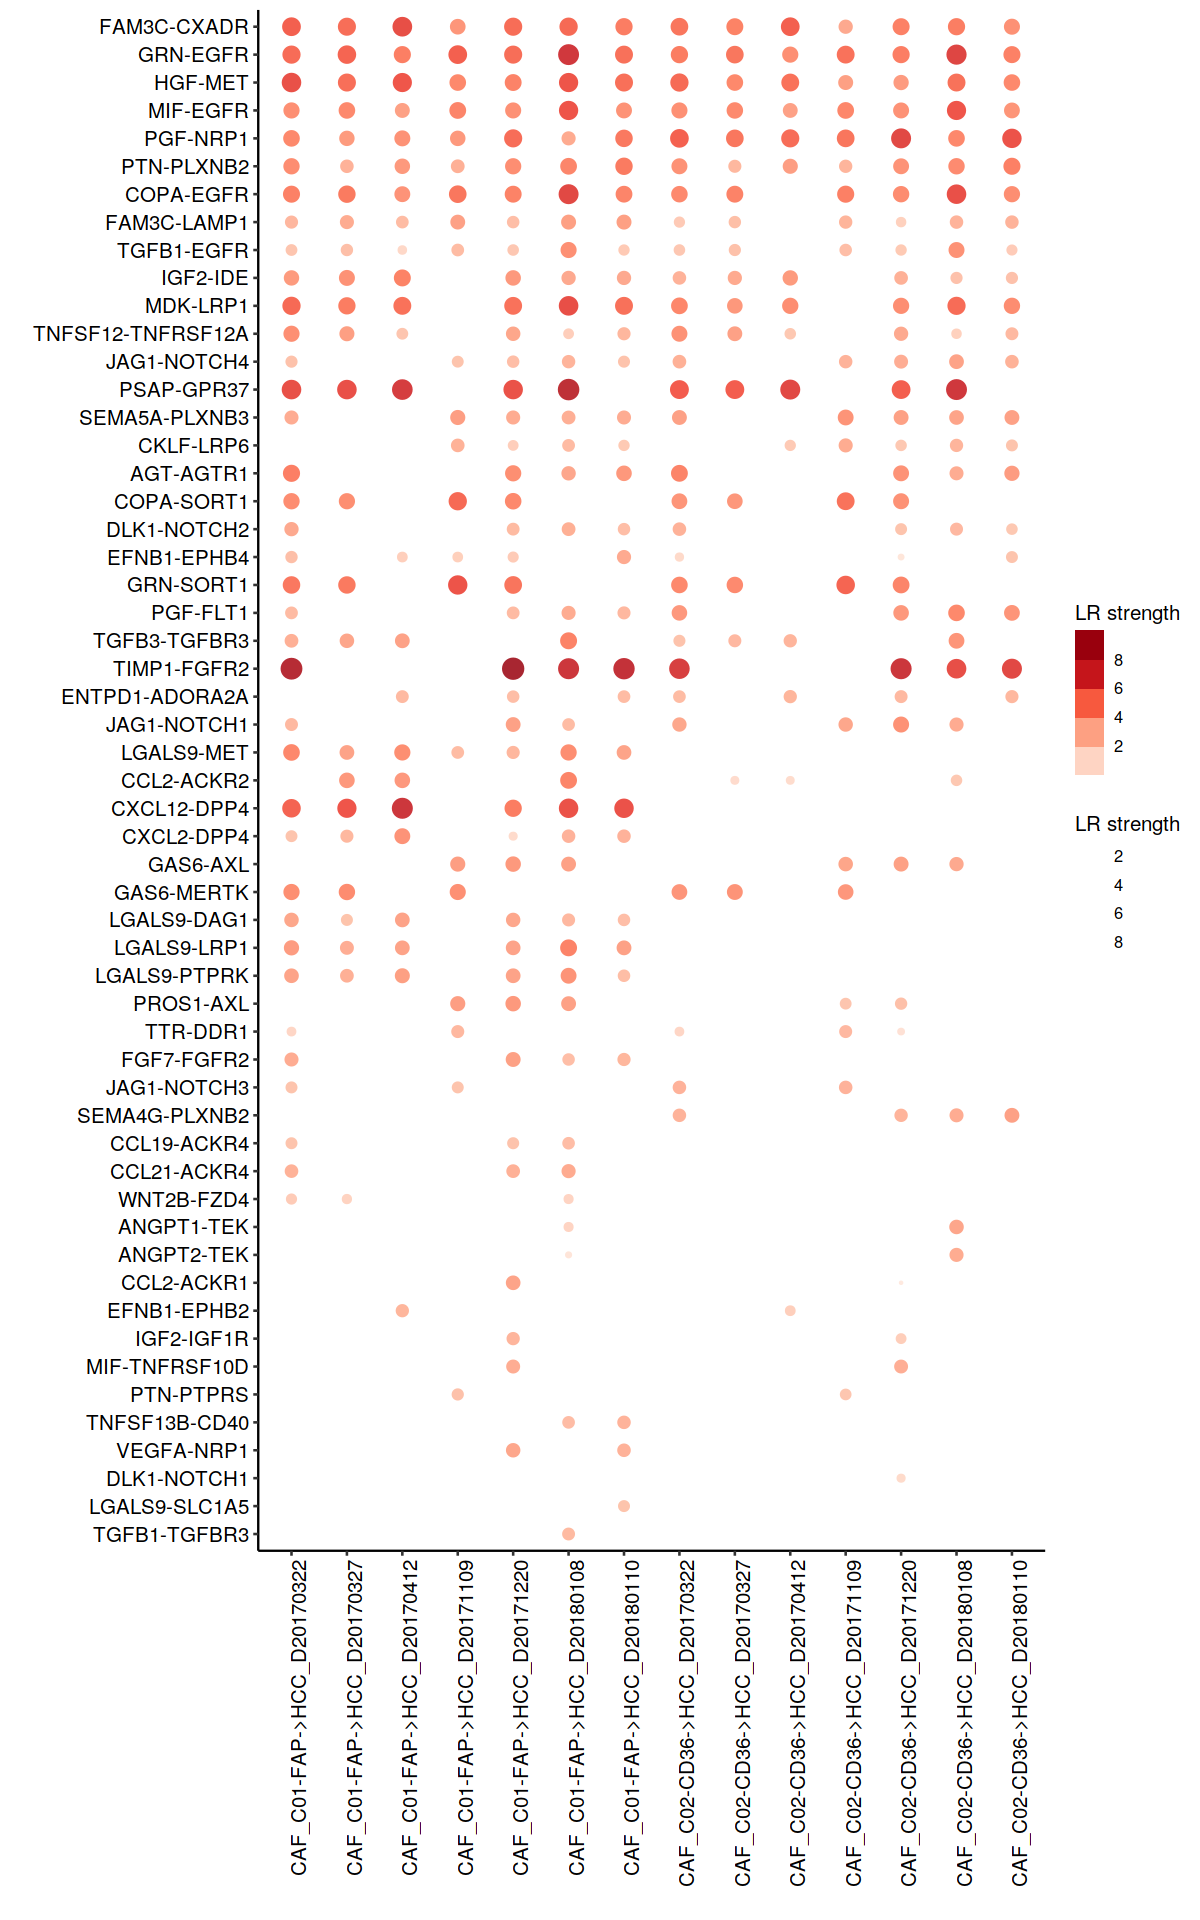

In [33]:
options(repr.plot.height = 16, repr.plot.width = 10)
p2 <- plotInteractDF %>% 
    filter(grepl("^HCC", receiver)) %>%
    mutate(LR = factor(LR, levels = rev(LRorder[[1]]))) %>% 
 mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    ggplot( aes(x =  paste0(sending, "->", receiver), y = LR)) +
  geom_point(aes(size = mean,  fill = mean, color = mean), shape = 21, alpha = .85,  stroke = .001 ) +
    scale_fill_distiller(palette = "Reds", direction = 1) + 
  scale_color_distiller(palette = "Reds", direction = 1) + 

    #scale_size(range = c(0, 10)) + 
    guides(fill = guide_colorsteps(title = 'LR strength'),color = guide_colorsteps(title = 'LR strength'), size = guide_legend(title = 'LR strength')) +
    ylab("") + xlab("") +
    ggpubr::theme_pubr() + theme(legend.position = 'right', axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) 
p2
#ggsave(p2, filename = "../figures/Figure2/2E_Dotplot_LR_CAF2Tumor.pdf", width = 6, height = 12)

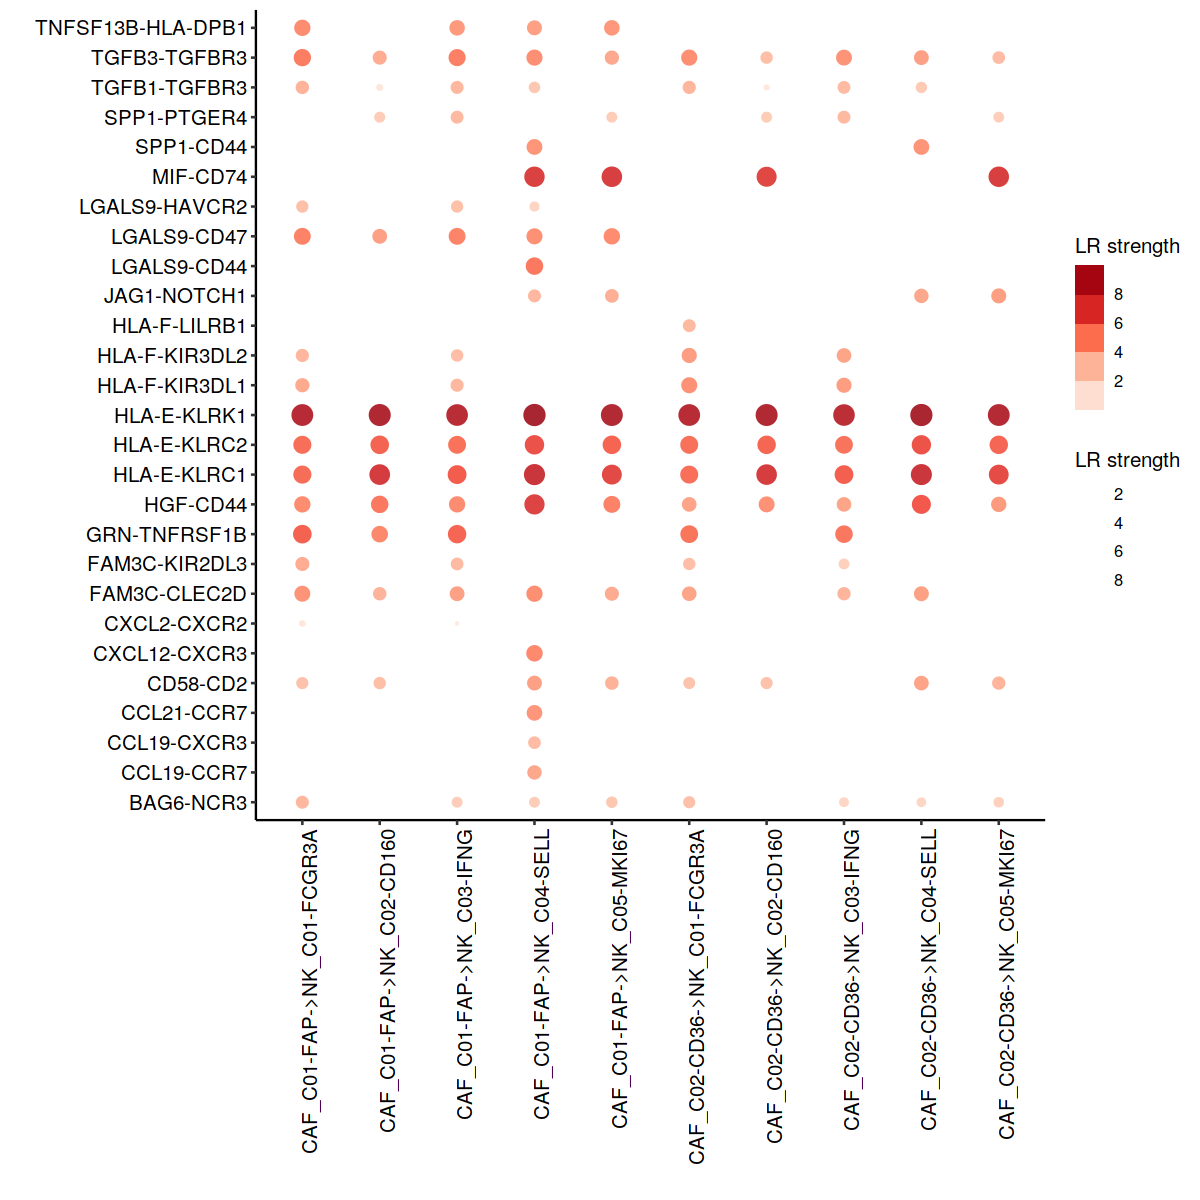

In [176]:
options(repr.plot.height = 10, repr.plot.width = 10)
p3 <- plotInteractDF %>% 
    filter(grepl("^NK", receiver)) %>%
    #mutate(LR = factor(LR, levels = rev(LRorder[[1]]))) %>% 
 mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    ggplot( aes(x =  paste0(sending, "->", receiver), y = LR)) +
   geom_point(aes(size = mean,  fill = mean, color = mean), shape = 21, alpha = .85,  stroke = .001 ) +
    scale_fill_distiller(palette = "Reds", direction = 1) + 
   scale_color_distiller(palette = "Reds", direction = 1) + 

    #scale_size(range = c(0, 10)) + 
    guides(fill = guide_colorsteps(title = 'LR strength'),color = guide_colorsteps(title = 'LR strength'), size = guide_legend(title = 'LR strength')) +
    ylab("") + xlab("") +
    ggpubr::theme_pubr() + theme(legend.position = 'right', axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) 
p3

ggsave(p3, filename = "../figures/Figure2/2F_Dotplot_LR_CAF2NK.pdf", width = 6, height = 6)

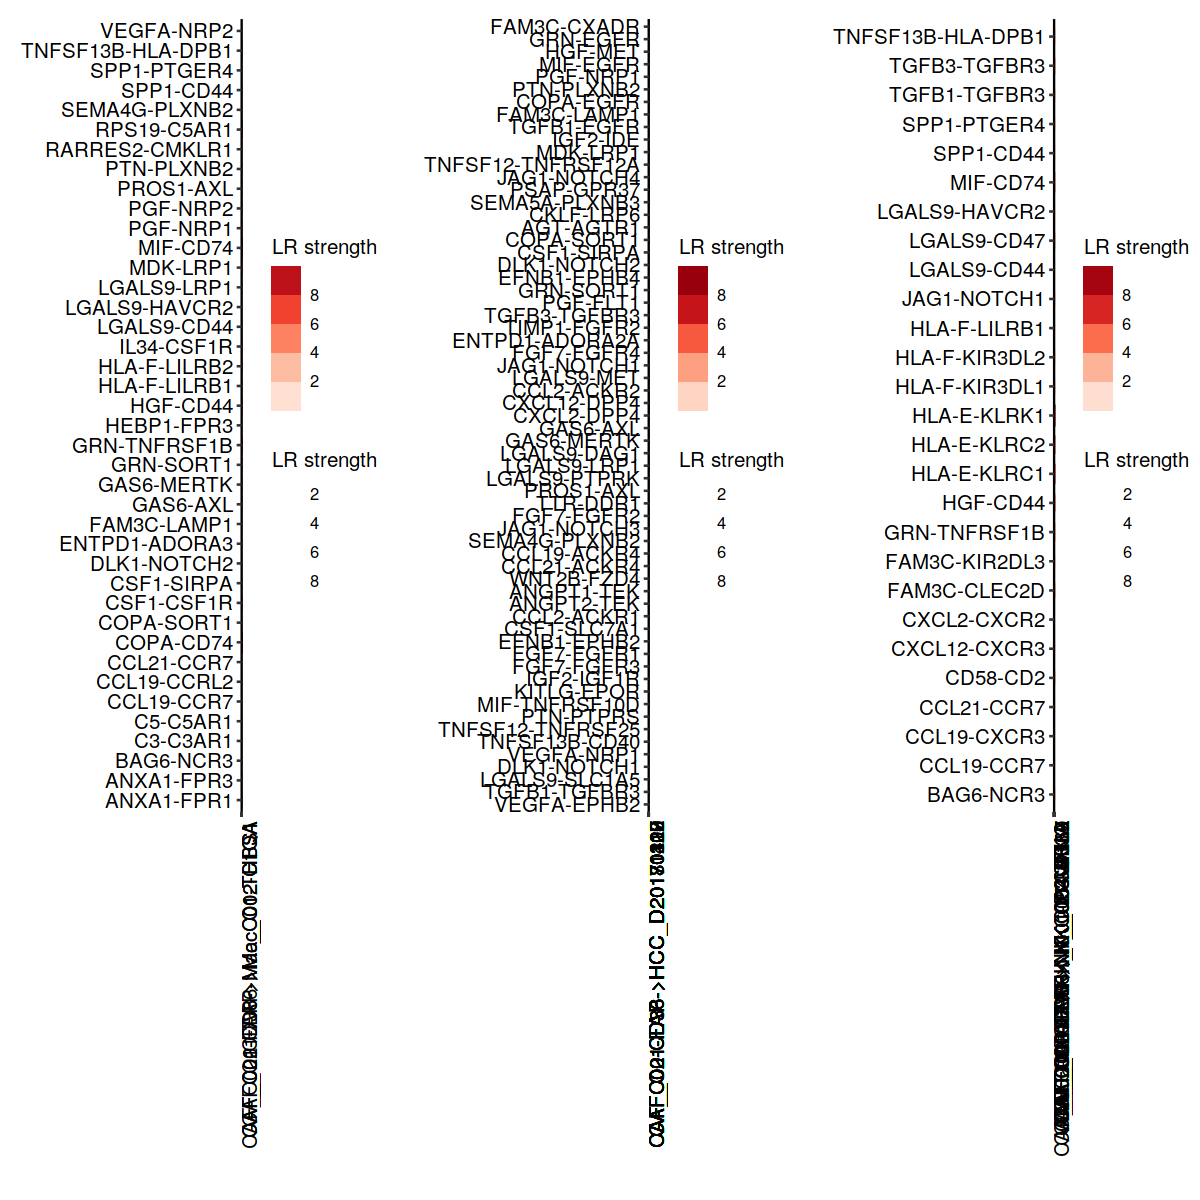

In [182]:
library(patchwork)
p <- p1 + p2 + p3  + plot_layout(widths = c(1, 2, 1.5))
p
#
ggsave(p, filename = "../figures/Figure2/2DEF_Dotplot_LR_CAF2any.pdf", width = 16, height = 10)


In [51]:
topInteract_CAF2NK %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 1)

LR,count
<chr>,<int>
CCL21-CCR7,1
CXCL12-CXCR4,1
LGALS9-CD44,1
LGALS9-CD47,1
LGALS9-HAVCR2,1
LGALS9-SORL1,1
OGN-HLA-DRB1,1
TNFSF13B-HLA-DPB1,1


In [46]:
topInteract_CAF2NK %>% filter(greplligand)

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,cluster_b,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CPI-SS06C0074BD,CAF_C01.FAP|NK_C04.SELL,0,4.345,CCL21_CCR7,simple:O00585,simple:P32248,CCL21,CCR7,TRUE,⋯,NK_C04.SELL,CAF_C01-FAP,CCL21,NK_C04-SELL,CCR7,0.6551724,6.182388,0.6470588,3.978467,CCL21-CCR7
CPI-SS098EFF959,NK_C04.SELL|CAF_C01.FAP,0,3.748,CCR7_CCL19,simple:P32248,simple:Q99731,CCR7,CCL19,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CCL19,NK_C04-SELL,CCR7,0.4310345,4.665991,0.6470588,3.978467,CCL19-CCR7
CPI-SS003610FF9,NK_C04.SELL|CAF_C01.FAP,0,3.083,CXCR3_CCL19,simple:P49682,simple:Q99731,CXCR3,CCL19,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CCL19,NK_C04-SELL,CXCR3,0.4310345,4.665991,0.4117647,2.715208,CCL19-CXCR3


In [41]:
topInteract_CAF2Mac %>% filter(ligand %in% c('CCL19', "CCL21"))

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,cluster_b,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CPI-SS06C0074BD,CAF_C01.FAP|Mac_C02.C1QA,0,2.836,CCL21_CCR7,simple:O00585,simple:P32248,CCL21,CCR7,TRUE,⋯,Mac_C02.C1QA,CAF_C01-FAP,CCL21,Mac_C02-C1QA,CCR7,0.6551724,6.182388,0.3081081,0.8104365,CCL21-CCR7
CPI-SS056BE1011,Mac_C01.THBS1|CAF_C01.FAP,0,3.058,CCRL2_CCL19,simple:O00421,simple:Q99731,CCRL2,CCL19,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CCL19,Mac_C01-THBS1,CCRL2,0.4310345,4.665991,0.3896458,2.3975507,CCL19-CCRL2
CPI-SS056BE1011,Mac_C02.C1QA|CAF_C01.FAP,0,3.040,CCRL2_CCL19,simple:O00421,simple:Q99731,CCRL2,CCL19,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CCL19,Mac_C02-C1QA,CCRL2,0.4310345,4.665991,0.3783784,2.3606904,CCL19-CCRL2
CPI-SS098EFF959,Mac_C02.C1QA|CAF_C01.FAP,0,2.240,CCR7_CCL19,simple:P32248,simple:Q99731,CCR7,CCL19,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CCL19,Mac_C02-C1QA,CCR7,0.4310345,4.665991,0.3081081,0.8104365,CCL19-CCR7


In [37]:
topInteract_CAF2Mac %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 1)

LR,count
<chr>,<int>
C5-C5AR1,1
CCL19-CCR7,1
CCL19-CCRL2,1
CCL21-CCR7,1
CXCL12-CXCR4,1
LGALS9-CD44,1
LGALS9-HAVCR2,1
LGALS9-LRP1,1
LGALS9-SORL1,1


In [39]:
topInteract_CAF2Mac %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 2)

LR,count
<chr>,<int>
ANXA1-FPR1,2
ANXA1-FPR3,2
APP-CD74,2
BAG6-NCR3,2
C3-C3AR1,2
COPA-CD74,2
COPA-SORT1,2
CSF1-CSF1R,2
CSF1-SIRPA,2


In [36]:
topInteract_CAF2tumor %>% 
    distinct(sending, receiver, ligand, receptor, LR, mean, pvalue)   %>% 
    distinct( sending, LR) %>% group_by(LR) %>% summarise(count = n()) %>% filter(count == 1)

LR,count
<chr>,<int>
APP-CD74,1
CCL21-ACKR4,1
CXCL12-DPP4,1
EFNA1-EPHA2,1
EFNB1-EPHB2,1
EFNB1-EPHB4,1
EFNB1-EPHB6,1
FAM3C-HLA-C,1
LGALS9-DAG1,1


In [19]:
topInteract_CAF2tumor %>% filter(ligand == 'CXCL12')

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,cluster_b,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CPI-SS0DBA4D668,HCC_D20170322|CAF_C01.FAP,0,5.393,DPP4_CXCL12,simple:P27487,simple:P48061,DPP4,CXCL12,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CXCL12,HCC_D20170322,DPP4,0.7758621,6.480158,0.6153846,3.386599,CXCL12-DPP4
CPI-SS0DBA4D668,HCC_D20170327|CAF_C01.FAP,0,5.810,DPP4_CXCL12,simple:P27487,simple:P48061,DPP4,CXCL12,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CXCL12,HCC_D20170327,DPP4,0.7758621,6.480158,0.6886228,4.164089,CXCL12-DPP4
CPI-SS0DBA4D668,HCC_D20170412|CAF_C01.FAP,0,7.031,DPP4_CXCL12,simple:P27487,simple:P48061,DPP4,CXCL12,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CXCL12,HCC_D20170412,DPP4,0.7758621,6.480158,0.9375000,6.454550,CXCL12-DPP4
CPI-SS0DBA4D668,HCC_D20180108|CAF_C01.FAP,0,5.969,DPP4_CXCL12,simple:P27487,simple:P48061,DPP4,CXCL12,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CXCL12,HCC_D20180108,DPP4,0.7758621,6.480158,0.7619048,4.417639,CXCL12-DPP4
CPI-SS0DBA4D668,HCC_D20180110|CAF_C01.FAP,0,5.963,DPP4_CXCL12,simple:P27487,simple:P48061,DPP4,CXCL12,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CXCL12,HCC_D20180110,DPP4,0.7758621,6.480158,0.7827715,4.412938,CXCL12-DPP4


In [18]:
topInteract_CAF2tumor %>% filter(ligand == 'HGF')

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,cluster_b,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CPI-SS07F60834D,HCC_D20170322|CAF_C01.FAP,0,6.018,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,HGF,HCC_D20170322,MET,0.7413793,4.695740,0.9230769,5.460596,HGF-MET
CPI-SS07F60834D,HCC_D20170322|CAF_C02.CD36,0,5.216,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C02.CD36,CAF_C02-CD36,HGF,HCC_D20170322,MET,0.6022989,3.306273,0.9230769,5.460596,HGF-MET
CPI-SS07F60834D,HCC_D20170327|CAF_C01.FAP,0,5.080,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,HGF,HCC_D20170327,MET,0.7413793,4.695740,0.7125749,3.814822,HGF-MET
CPI-SS07F60834D,HCC_D20170327|CAF_C02.CD36,0,4.278,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C02.CD36,CAF_C02-CD36,HGF,HCC_D20170327,MET,0.6022989,3.306273,0.7125749,3.814822,HGF-MET
CPI-SS07F60834D,HCC_D20170412|CAF_C01.FAP,0,5.790,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,HGF,HCC_D20170412,MET,0.7413793,4.695740,0.9375000,5.007213,HGF-MET
CPI-SS07F60834D,HCC_D20170412|CAF_C02.CD36,0,4.989,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C02.CD36,CAF_C02-CD36,HGF,HCC_D20170412,MET,0.6022989,3.306273,0.9375000,5.007213,HGF-MET
CPI-SS07F60834D,HCC_D20171109|CAF_C01.FAP,0,4.280,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,HGF,HCC_D20171109,MET,0.7413793,4.695740,0.6666667,2.370105,HGF-MET
CPI-SS07F60834D,HCC_D20171109|CAF_C02.CD36,0,3.478,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C02.CD36,CAF_C02-CD36,HGF,HCC_D20171109,MET,0.6022989,3.306273,0.6666667,2.370105,HGF-MET
CPI-SS07F60834D,HCC_D20171220|CAF_C01.FAP,0,4.431,MET_HGF,simple:P08581,simple:P14210,MET,HGF,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,HGF,HCC_D20171220,MET,0.7413793,4.695740,0.6455696,2.603243,HGF-MET


In [70]:
topInteract_CAF2NK  %>% filter(grepl("^CCL|^CXCL", ligand))

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,cluster_b,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CPI-SS0A28DCA72,CAF_C01.FAP|NK_C01.FCGR3A,0,6.272,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,TRUE,⋯,NK_C01.FCGR3A,CAF_C01-FAP,CXCL12,NK_C01-FCGR3A,CXCR4,0.7758621,6.480158,0.8323699,5.910767,CXCL12-CXCR4
CPI-SS0A28DCA72,CAF_C01.FAP|NK_C02.CD160,0,7.329,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,TRUE,⋯,NK_C02.CD160,CAF_C01-FAP,CXCL12,NK_C02-CD160,CXCR4,0.7758621,6.480158,0.9342105,8.092318,CXCL12-CXCR4
CPI-SS0A28DCA72,CAF_C01.FAP|NK_C03.IFNG,0,7.215,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,TRUE,⋯,NK_C03.IFNG,CAF_C01-FAP,CXCL12,NK_C03-IFNG,CXCR4,0.7758621,6.480158,0.9594595,7.886697,CXCL12-CXCR4
CPI-SS06C0074BD,CAF_C01.FAP|NK_C04.SELL,0,4.345,CCL21_CCR7,simple:O00585,simple:P32248,CCL21,CCR7,TRUE,⋯,NK_C04.SELL,CAF_C01-FAP,CCL21,NK_C04-SELL,CCR7,0.6551724,6.182388,0.6470588,3.978467,CCL21-CCR7
CPI-SS0EFE0B07A,CAF_C01.FAP|NK_C04.SELL,0,4.750,CXCL12_CXCR3,simple:P48061,simple:P49682,CXCL12,CXCR3,TRUE,⋯,NK_C04.SELL,CAF_C01-FAP,CXCL12,NK_C04-SELL,CXCR3,0.7758621,6.480158,0.4117647,2.715208,CXCL12-CXCR3
CPI-SS0A28DCA72,CAF_C01.FAP|NK_C04.SELL,0,6.326,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,TRUE,⋯,NK_C04.SELL,CAF_C01-FAP,CXCL12,NK_C04-SELL,CXCR4,0.7758621,6.480158,0.8039216,6.019836,CXCL12-CXCR4
CPI-SS0A28DCA72,CAF_C01.FAP|NK_C05.MKI67,0,7.801,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,TRUE,⋯,NK_C05.MKI67,CAF_C01-FAP,CXCL12,NK_C05-MKI67,CXCR4,0.7758621,6.480158,0.9629630,9.074373,CXCL12-CXCR4
CPI-SS098EFF959,NK_C04.SELL|CAF_C01.FAP,0,3.748,CCR7_CCL19,simple:P32248,simple:Q99731,CCR7,CCL19,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CCL19,NK_C04-SELL,CCR7,0.4310345,4.665991,0.6470588,3.978467,CCL19-CCR7
CPI-SS003610FF9,NK_C04.SELL|CAF_C01.FAP,0,3.083,CXCR3_CCL19,simple:P49682,simple:Q99731,CXCR3,CCL19,TRUE,⋯,CAF_C01.FAP,CAF_C01-FAP,CCL19,NK_C04-SELL,CXCR3,0.4310345,4.665991,0.4117647,2.715208,CCL19-CXCR3


In [67]:
topInteract_CAF2NK %>% 
   mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    #filter(secreted) %>% 
    filter(annotation_strategy != "I2D") %>%
    group_by(LR,ligand,receptor,  receiver) %>%
    summarise(count = n()) %>%
    tidyr::pivot_wider(id_cols = c('LR', 'ligand', 'receptor') , names_from = receiver, values_from = count,values_fill = 0)  %>%
    .$ligand %>% unique()

`summarise()` has grouped output by 'LR', 'ligand', 'receptor'. You can override using the `.groups` argument.



[1] "APP"      "BAG6"     "CCL19"    "CCL21"    "CXCL12"   "FAM3C"   
 [7] "GRN"      "HGF"      "HLA-E"    "HLA-F"    "IGF2"     "JAG1"    
[13] "MDK"      "MIF"      "OGN"      "TGFB3"    "TNFSF13B"

In [63]:
topInteract_CAF2Mac %>% 
   mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    #filter(secreted) %>% 
    filter(annotation_strategy != "I2D") %>%
    group_by(LR,ligand,receptor,  receiver) %>%
    summarise(count = n()) %>%
    tidyr::pivot_wider(id_cols = c('LR', 'ligand', 'receptor') , names_from = receiver, values_from = count,values_fill = 0)  %>%
    .$ligand %>% unique()
    #tidyr::separate(LR, into = c("Ligand", "Receptor"), sep = "-") %>%
    #openxlsx::write.xlsx("test.xlsx")

`summarise()` has grouped output by 'LR', 'ligand', 'receptor'. You can override using the `.groups` argument.



[1] "ANXA1"    "APP"      "BAG6"     "C3"       "CCL19"    "COPA"    
 [7] "CSF1"     "CXCL12"   "ENTPD1"   "FAM3C"    "GAS6"     "GRN"     
[13] "HEBP1"    "HGF"      "HLA-F"    "IL34"     "JAG1"     "MDK"     
[19] "MIF"      "OGN"      "PGF"      "PROS1"    "PTN"      "RARRES2" 
[25] "RPS19"    "TNFSF13B"

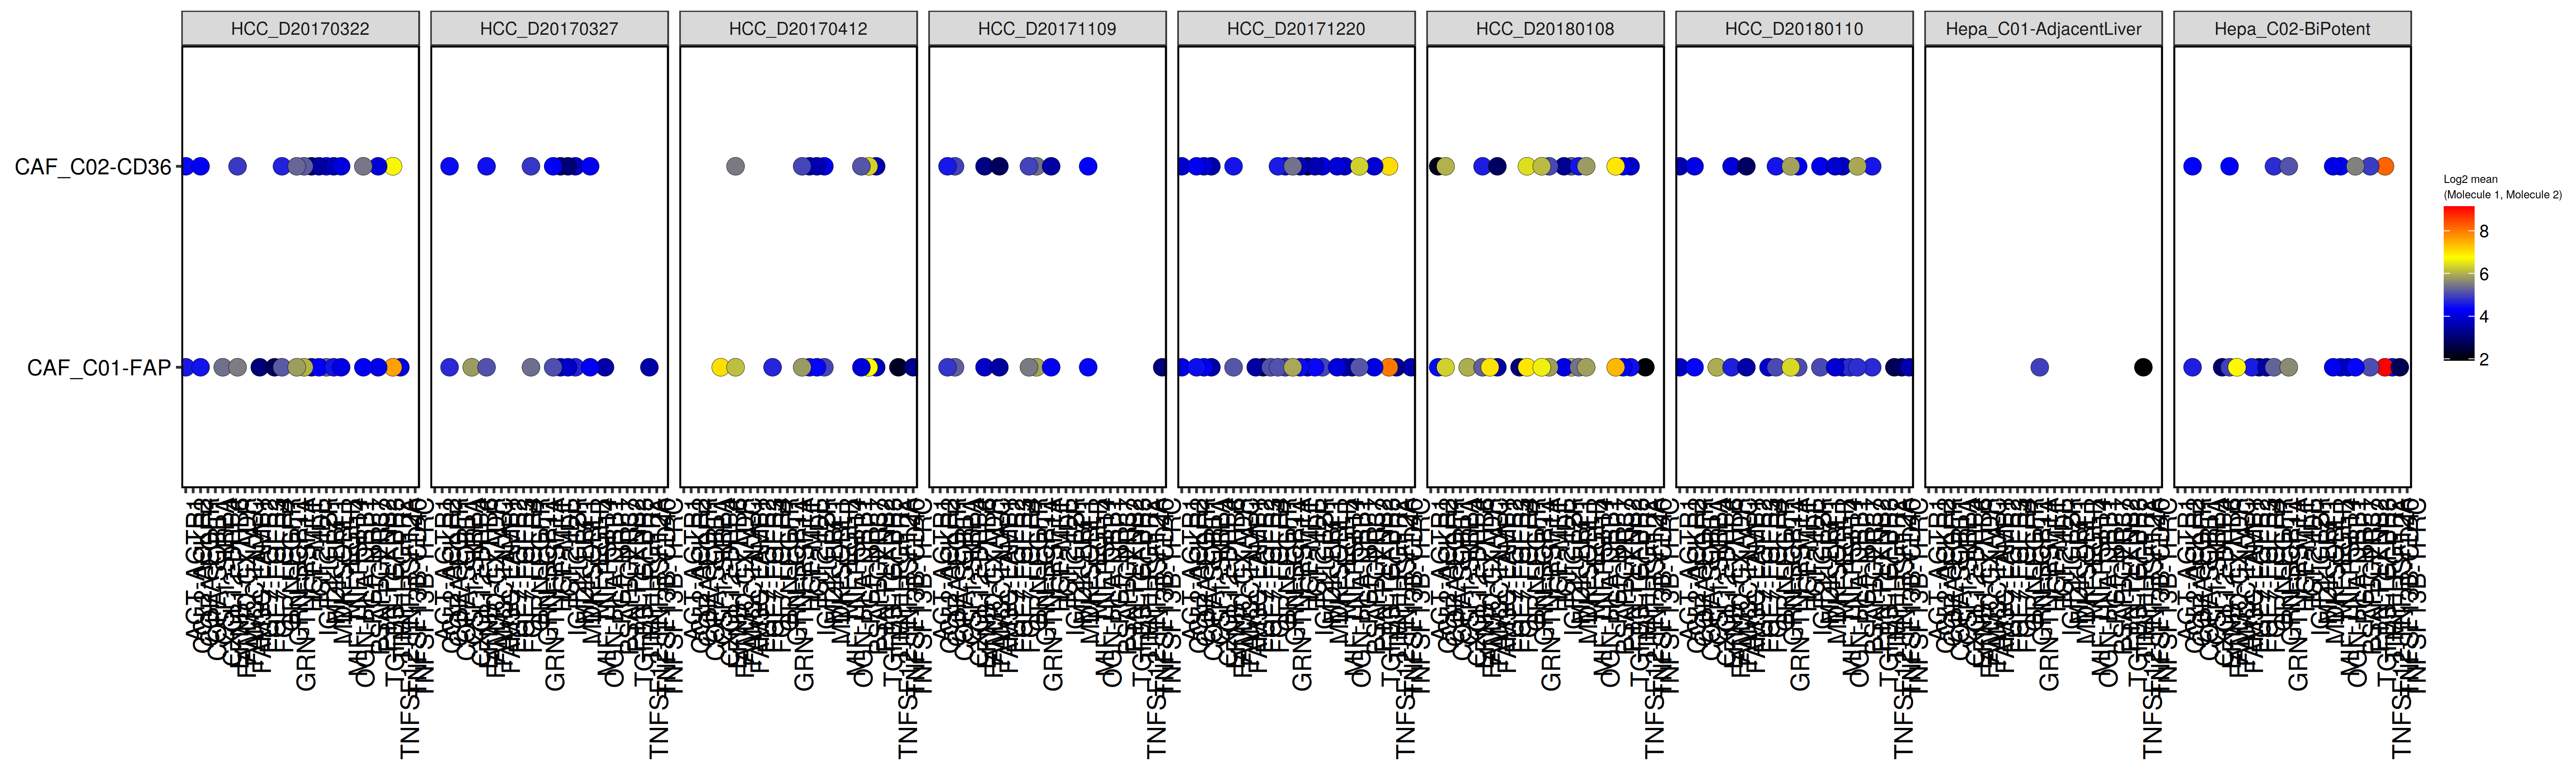

In [58]:
options(repr.plot.width = 20, repr.plot.height = 6, repr.plot.res = 300)
  my_palette <- colorRampPalette(c("black", "blue", "yellow", "red"), alpha=TRUE)(n=399)
topInteract_CAF2tumor %>% 
   mutate(pvalue = case_when(pvalue == 0 ~ 0.009,
                            TRUE ~ pvalue)) %>%
    filter(secreted)  %>%
    ggplot(aes(y = LR, x = sending)) +
        geom_point(aes(size = -log10(pvalue),  fill = mean), shape = 21, color = 'black', stroke = .1 ) +
        scale_fill_gradientn('Log2 mean \n(Molecule 1, Molecule 2)', colors=my_palette, 
                             guide = guide_colorbar(title.theme = element_text(size = 6), title.position = "top", direction = "vertical" )) +
        facet_grid(. ~ receiver) +
        guides(size = guide_none()) + 
        coord_flip() + 
       theme_bw(base_size = 12) +
  theme(legend.position = 'right', panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.text=element_text(size=14, colour = "black"),
        axis.text.x = element_text(angle = 90, hjust = 1),
        axis.text.y = element_text(size=12, colour = "black"),
        axis.title=element_blank(),
        panel.border = element_rect(size = 0.7, linetype = "solid", colour = "black"))

In [6]:
openxlsx::write.xlsx(topInteract, file = "./out/D20171220_tumor2all/topInteract.xlsx")

# CAF to Mac

In [33]:
distinct(topInteract_CAF2Mac, ligand, receptor)

ligand,receptor
<chr>,<chr>
C5,C5AR1
C3,C3AR1
HGF,CD44
ANXA1,FPR3
DLK1,NOTCH2
ANXA1,FPR1
CSF1,SIRPA
PROS1,AXL
SPP1,PTGER4


In [34]:
topInteract_CAF2Mac %>% filter(ligand == 'CXCL12')

id_cp_interaction,cluster_pair,pvalue,mean,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,⋯,sending,ligand,receiver,receptor,fractionExprLigand,meanExprLigand,fractionExprReceptor,meanExprReceptor,LR,group
<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CPI-SS0A28DCA72,CAF_C01.FAP|Mac_C01.THBS1,0,7.739,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,TRUE,⋯,CAF_C01-FAP,CXCL12,Mac_C01-THBS1,CXCR4,0.7758621,6.480158,0.9645777,8.958334,CXCL12-CXCR4,Mac
CPI-SS0A28DCA72,CAF_C01.FAP|Mac_C02.C1QA,0,8.329,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,TRUE,⋯,CAF_C01-FAP,CXCL12,Mac_C02-C1QA,CXCR4,0.7758621,6.480158,0.9837838,10.159027,CXCL12-CXCR4,Mac
